In [1]:
import numpy as np
import pygl, sys, time
import scipy as sp
from scipy.io import savemat, loadmat
fft2  = np.fft.fft2
randn = np.random.randn
from tqdm import trange
 


In [2]:
def configPlot(U, fig, n_, i):
    import matplotlib.pyplot as plt
    sp =  fig.add_subplot(1, 4, n_ )   

    im=plt.pcolor(U, cmap=plt.cm.RdBu_r);  plt.clim(-1.1, 1.1);
    cbar = plt.colorbar(im,fraction=0.04, pad=0.05, orientation="horizontal", 
                        ticks=[-1, 0, 1])

    plt.axis('off'); plt.title('T = %1.2E'%(i))

In [ ]:
class activeModels():
    '''Class to solve a active models'''
    def __init__(self, Nt, dt, dd, rhs):
        self.Nt = Nt
        self.dt = dt
        self.dd = dd
        
        self.rhs = rhs 
        self.XX  = np.zeros((int(self.dd+1), Ng*Ng)) 
        
    def integrate(self, u):
        '''  simulates the equation and plots it at different instants '''
        ii=0
        #fW = open('N%s_z%2.2f_l%2.2f_kh%4.4f_u%2.2f_a%4.4f_fd.txt'%(Ng, zeta, ll, kh, phi0, a), 'w')
        #fW.write('Ng%s_zeta%s_ ll%s_kh%s_phi0%s_a%s_b%s_k%s_dt%s_nfac%s_Ng%s_Nt%s \n'%(Ng, zeta, ll, kh, phi0, a, b,k, dt, nfac, Ng, Nt))
        t1 = time.perf_counter()
        
        for i in trange(self.Nt):          
            if time.perf_counter() - t1 > 42000:
                break    
            u = u + self.dt*self.rhs(u)
            if i%(int(self.Nt/self.dd))==0:  
                self.XX[ii,:] = u.flatten()
                ii += 1 
                #fW.write('%s\n'%u.flatten() )
    

# now set-up the simulation 
a, b, k  = -.25, .25, 1
zeta, ll = 2, -2
phi0 = .6

dim, h, st = 2, 1, 5
Nt, dt, dd = int(1e4), .01, 1000 
Ng2 = Ng*Ng

eta  = 1
grid = {"dim":dim, "Nx":Ng, "Ny":Ng}
ff = pygl.utils.FiniteDifference(grid)
stokes = pygl.solvers.Stokes(eta, grid)

Teff=0.1#nfac = Ng*Ng, np.sqrt(2*Teff/(h*h*dt))
nfac=2


def rhs(u):
    '''
    returns the right hand side of \dot{phi} in active model H
    \dot{u} = Δ(a*u + b*u*u*u + kΔu + λ(∇u)^2) - v.∇u (solve for fluid)
    '''
    #print( t, np.max(u))
    
    u_x=ff.diffx(u);  u_y=ff.diffy(u);  upp=ff.laplacian(u);  
    gp2 = 0.5*(u_x*u_x + u_y*u_y)
    chemPot = -.25*u + .25*u*u*u - upp + 2*ll*gp2
    jx  = -ff.diffx1(chemPot) + nfac*randn(Ng,Ng) + zeta*upp*u_x 
    jy  = -ff.diffy1(chemPot) + nfac*randn(Ng,Ng) + zeta*upp*u_y 
    du  = ff.diffx1(jx) + ff.diffy1(jy)
    return -du 

24 % done


/var/folders/l8/ng3lbfb14h1df_z4_lf3lnj80000gn/T/ipykernel_3908/2358531104.py:13: RuntimeWarning: overflow encountered in multiply
  t1 = time.perf_counter();     am.integrate(fft2(phi0) )
/var/folders/l8/ng3lbfb14h1df_z4_lf3lnj80000gn/T/ipykernel_3908/2358531104.py:13: RuntimeWarning: invalid value encountered in multiply
  t1 = time.perf_counter();     am.integrate(fft2(phi0) )


49 % done
74 % done
99 % done
total time taken:  236.13380875000075


/var/folders/l8/ng3lbfb14h1df_z4_lf3lnj80000gn/T/ipykernel_3908/1530217875.py:6: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im,fraction=0.04, pad=0.05, orientation="horizontal",


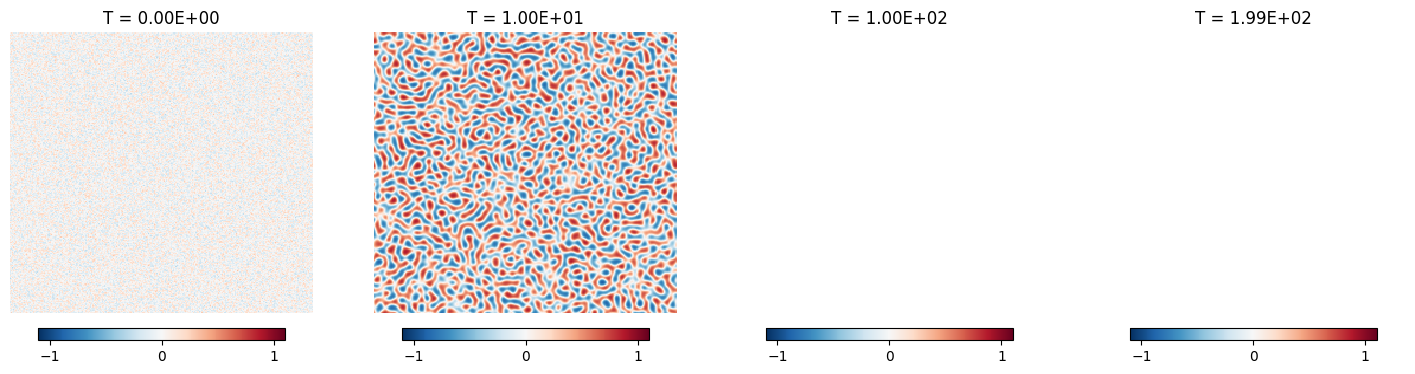

In [14]:
Deff, Ng = 0, 256; 

Nt, dt, Nf = int(6e4), .005, 200
phi0 = 0.0 + 0.25*(1-2*np.random.random((Ng,Ng)))          
Df=0.5*np.sqrt(2*Deff/dt);


param = {'h':1, 'Ng':Ng, 'a':-1, 'b':1, 'kp':1,
         'Nt':Nt, 'dt':dt, 'Nf':Nf, 'Df':Df}


am = pygl.solvers.ModelB(param)
t1 = time.perf_counter();     am.integrate(fft2(phi0) )

print ('total time taken: ', time.perf_counter()-t1)


fig = plt.figure(num=None, figsize=(18, 4), dpi=100);
ti=0;     configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 1, ti)
ti=10;    configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 2, ti)
ti=100;   configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 3, ti)
ti=199;   configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 4, ti);

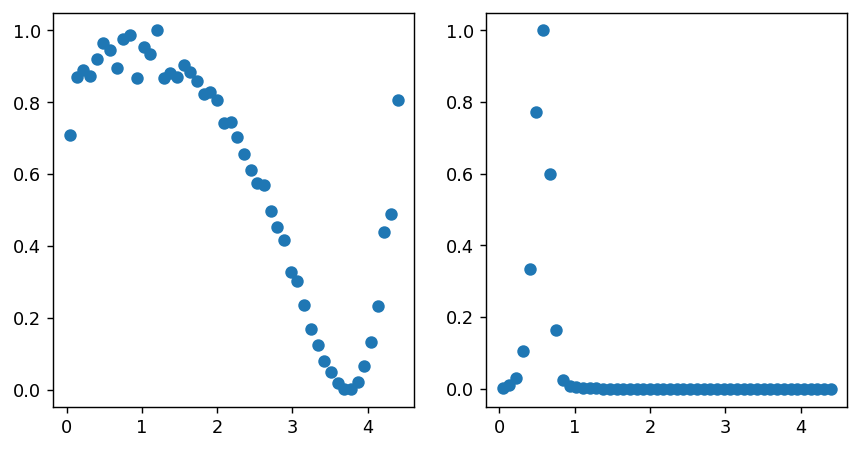

In [15]:
fig = plt.figure(num=None, figsize=(8, 4), dpi=128);
dim=2
i=0
plt.subplot(121)
stFac = pygl.utils.structureFactor(am.XX[i, :].reshape(Ng,Ng), dim)
avgS, kk = pygl.utils.avgStructFunc(stFac, 50, dim)
avgS = avgS/np.max(avgS)
plt.plot(kk, avgS, 'o')


plt.subplot(122); i = 10
stFac = pygl.utils.structureFactor(am.XX[i, :].reshape(Ng,Ng), dim)
avgS, kk = pygl.utils.avgStructFunc(stFac, 50, dim)
avgS = avgS/np.max(avgS)
plt.plot(kk, avgS, 'o')

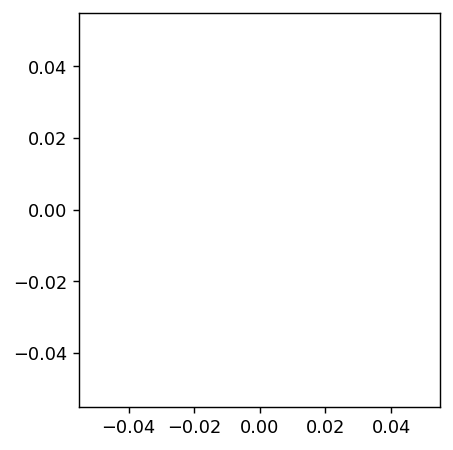

In [16]:
fig = plt.figure(num=None, figsize=(8, 4), dpi=128);
dim=2
i=199
plt.subplot(121)
stFac = pygl.utils.structureFactor(am.XX[i, :].reshape(Ng,Ng), dim)
corr = np.real(ifft2(stFac))
avgC, rr = pygl.utils.avgCorrFunc(corr, 100, dim)
# avgC = avgC/np.max(avgC)
plt.plot(rr, avgC, 'o')



In [17]:
rr

array([  1.80312229,   5.40936688,   9.01561146,  12.62185604,
        16.22810063,  19.83434521,  23.4405898 ,  27.04683438,
        30.65307896,  34.25932355,  37.86556813,  41.47181272,
        45.0780573 ,  48.68430188,  52.29054647,  55.89679105,
        59.50303564,  63.10928022,  66.7155248 ,  70.32176939,
        73.92801397,  77.53425856,  81.14050314,  84.74674773,
        88.35299231,  91.95923689,  95.56548148,  99.17172606,
       102.77797065, 106.38421523, 109.99045981, 113.5967044 ,
       117.20294898, 120.80919357, 124.41543815, 128.02168273,
       131.62792732, 135.2341719 , 138.84041649, 142.44666107,
       146.05290565, 149.65915024, 153.26539482, 156.87163941,
       160.47788399, 164.08412857, 167.69037316, 171.29661774,
       174.90286233, 178.50910691, 182.11535149, 185.72159608,
       189.32784066, 192.93408525, 196.54032983, 200.14657441,
       203.752819  , 207.35906358, 210.96530817, 214.57155275,
       218.17779734, 221.78404192, 225.3902865 , 228.99